In [1]:
from src.datamodules.sr_datamodule import *
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np

In [2]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(16, 16))
    for i, img in enumerate(imgs):
        img = img.detach()
        print(img.min(), img.max())
        img = F.to_pil_image(img)
        print(np.asarray(img).min(), np.asarray(img).max())
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [3]:
dm = SRDataModule(bin=True, reset_bin=False)
dm.prepare_data()
dm.setup()

In [4]:
dm.hparams.trainsets

[('DIV2K', 'train')]

In [5]:
dm.hparams.testsets

[('DIV2K', 'train'),
 ('benchmark', 'B100'),
 ('benchmark', 'Set5'),
 ('benchmark', 'Set14'),
 ('benchmark', 'Urban100')]

In [6]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loaders = dm.test_dataloader()

In [7]:
print(len(train_loader.dataset))
print(len(val_loader.dataset))
print([len(test_loader.dataset) for test_loader in test_loaders])

16000
100
[100, 100, 5, 14, 100]


tensor(0.) tensor(1.)
0 255
tensor(0.) tensor(1.)
0 255
tensor(0.) tensor(1.)
0 255
tensor(0.) tensor(1.)
0 255
tensor(0.) tensor(1.)
0 255
tensor(0.) tensor(1.)
0 255
tensor(0.0078) tensor(0.9686)
2 247
tensor(0.0235) tensor(0.9608)
6 245
tensor(0.) tensor(1.)
0 255
tensor(0.) tensor(1.)
0 255


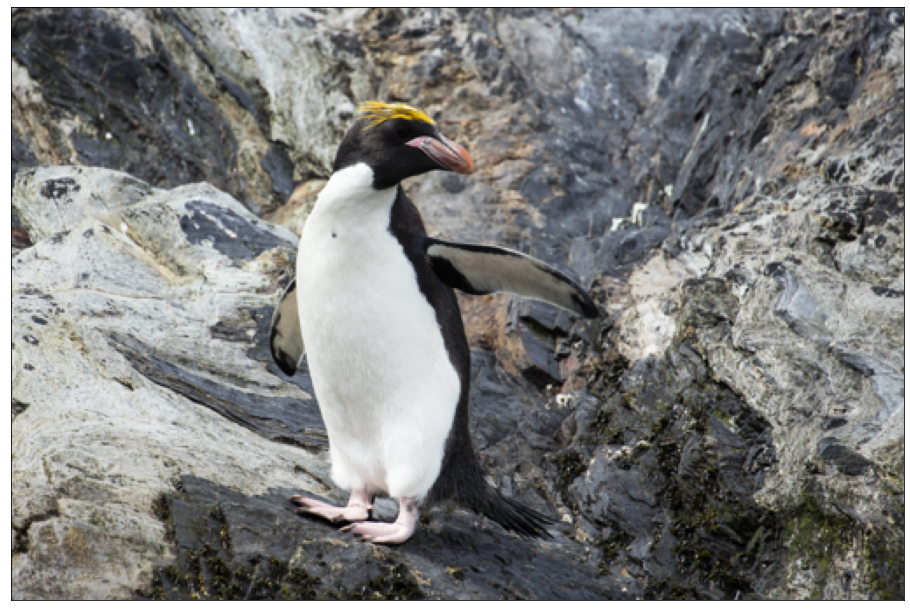

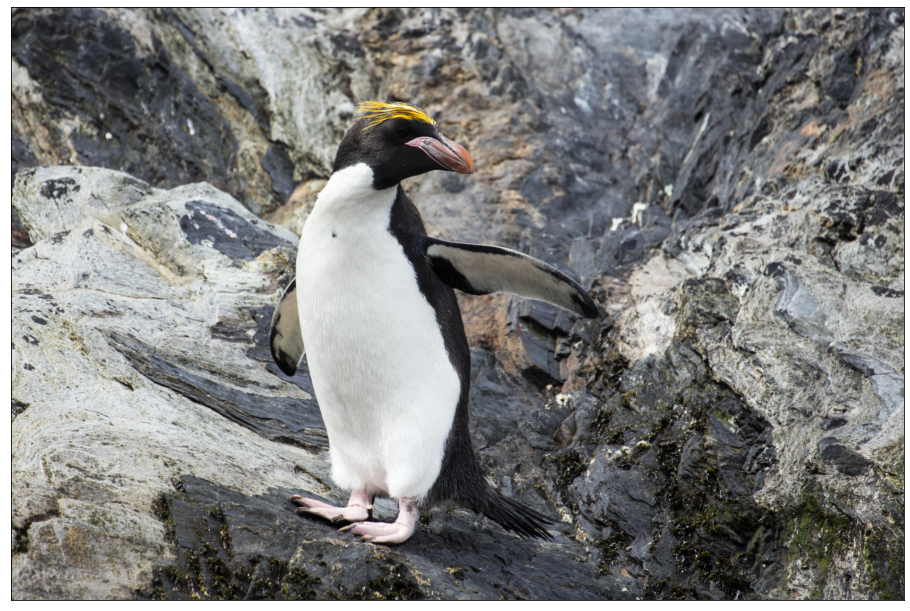

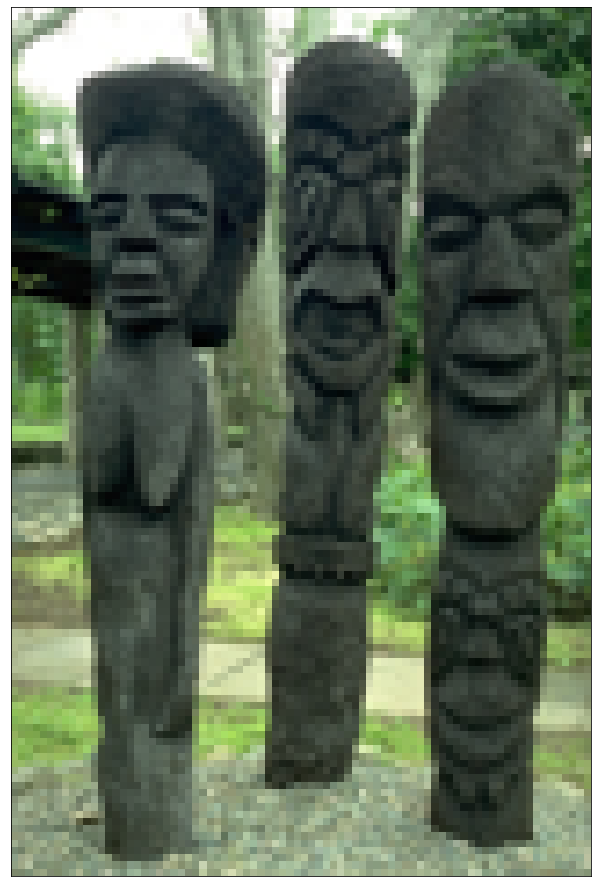

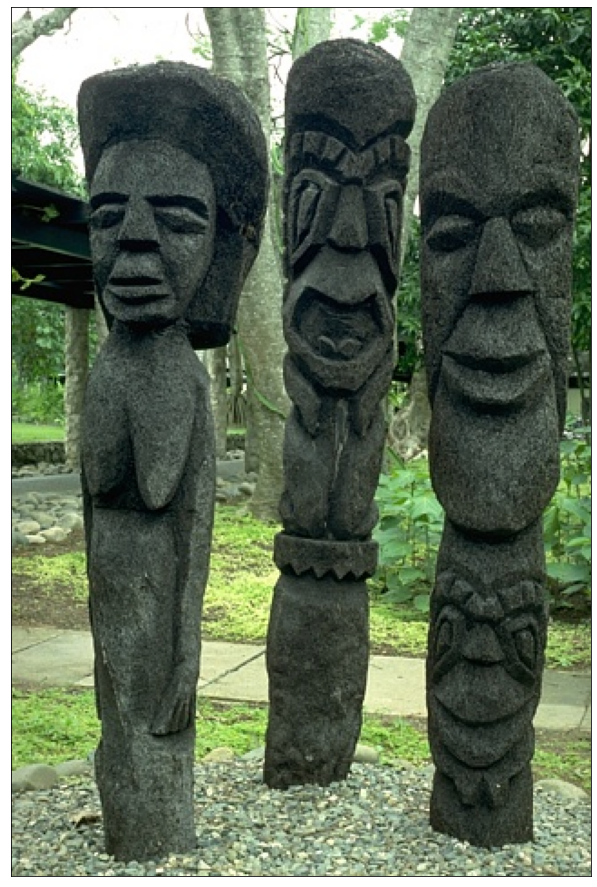

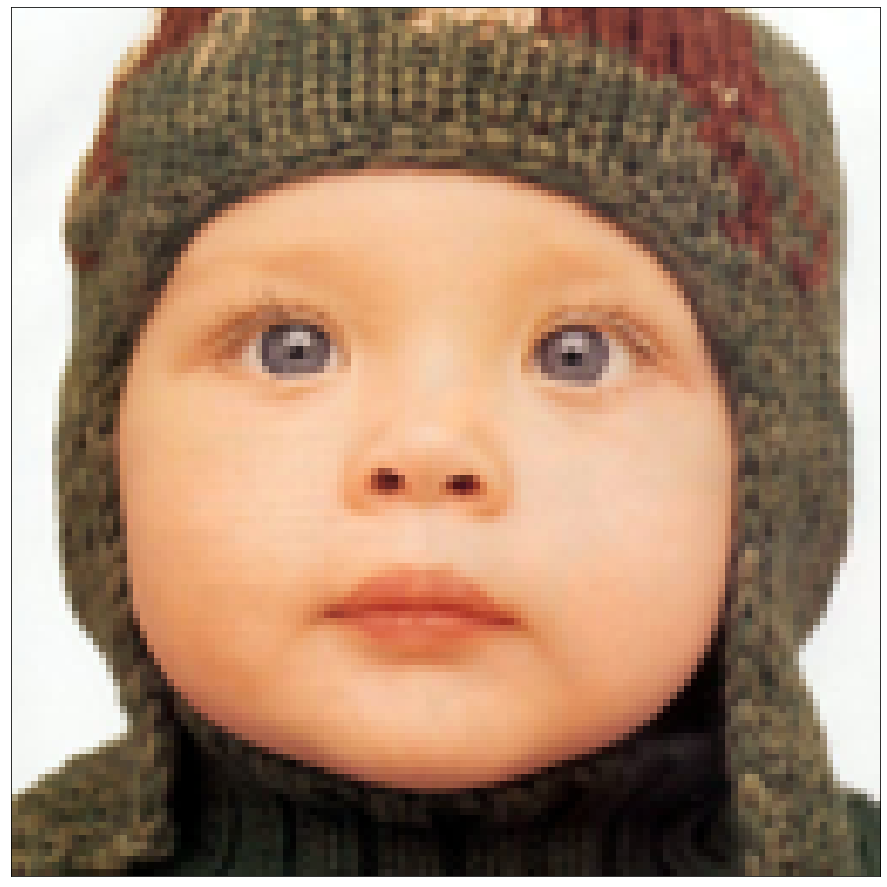

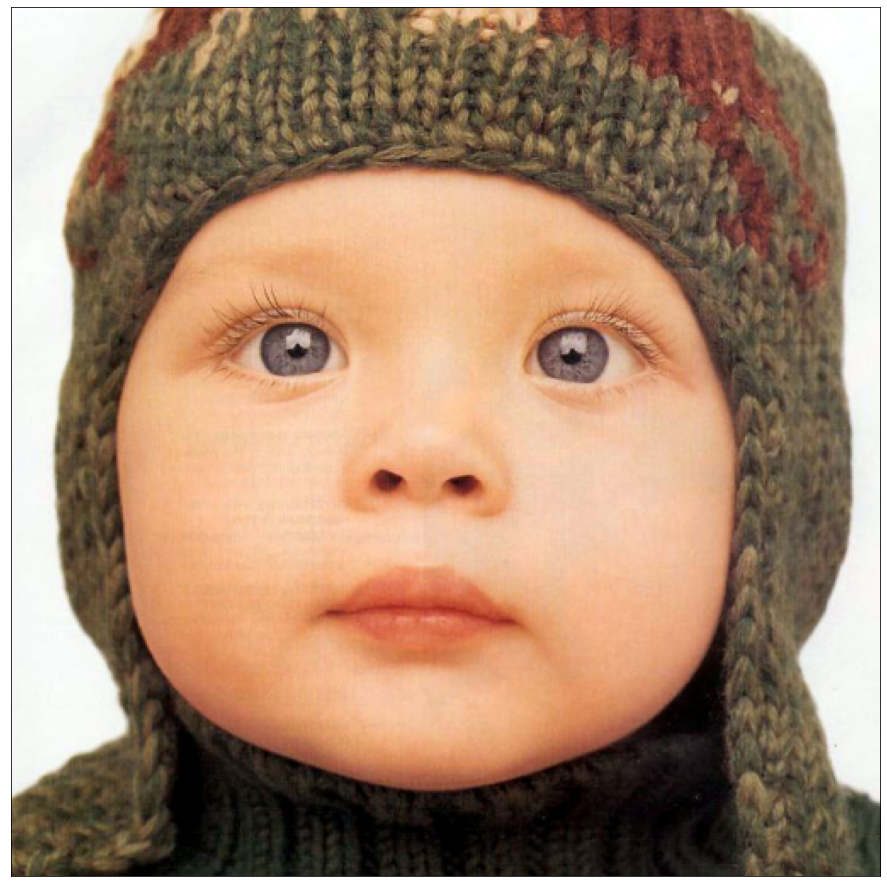

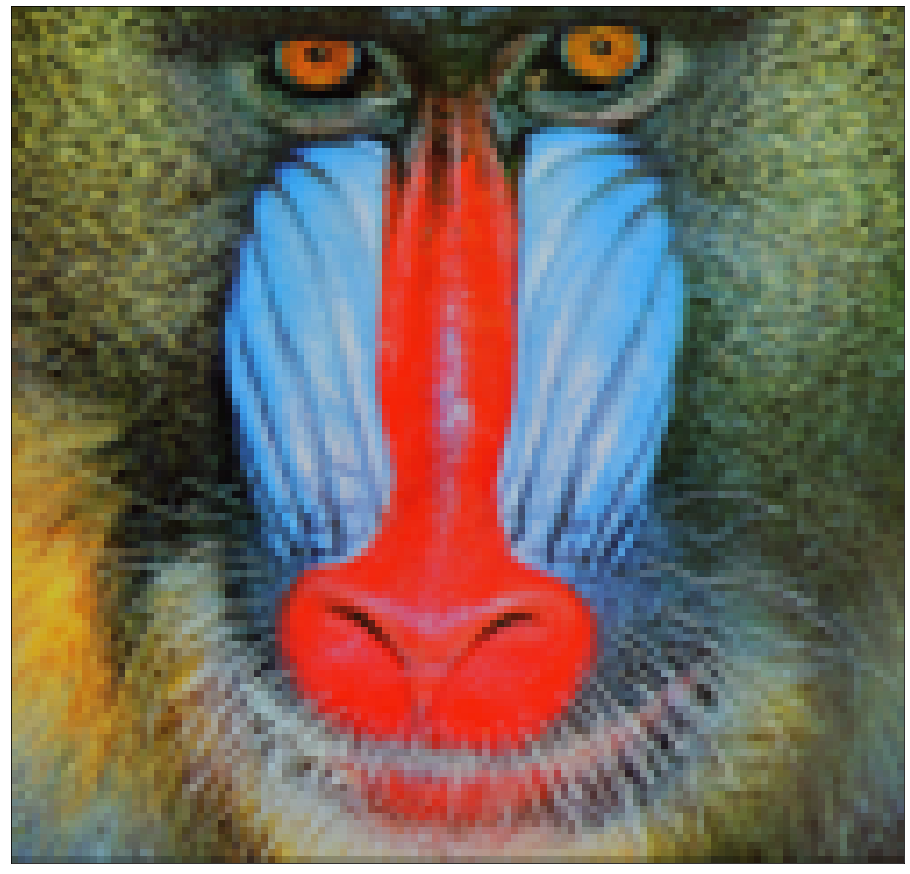

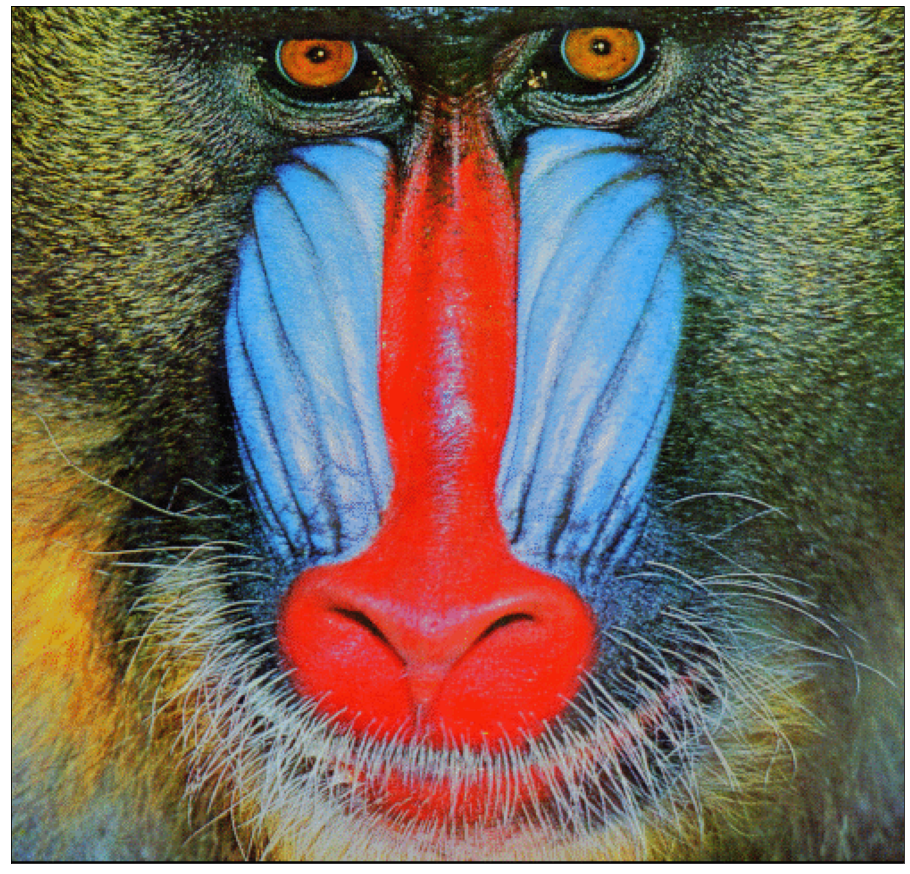

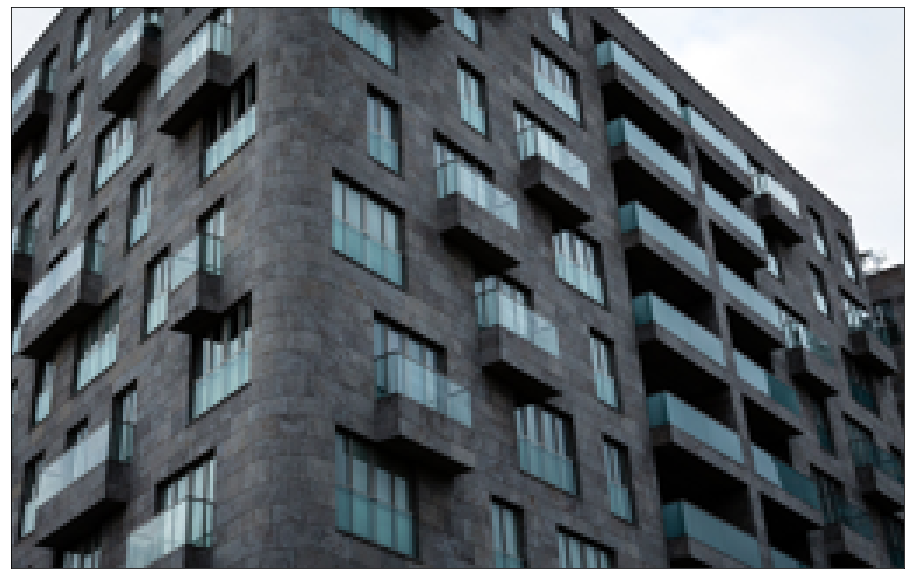

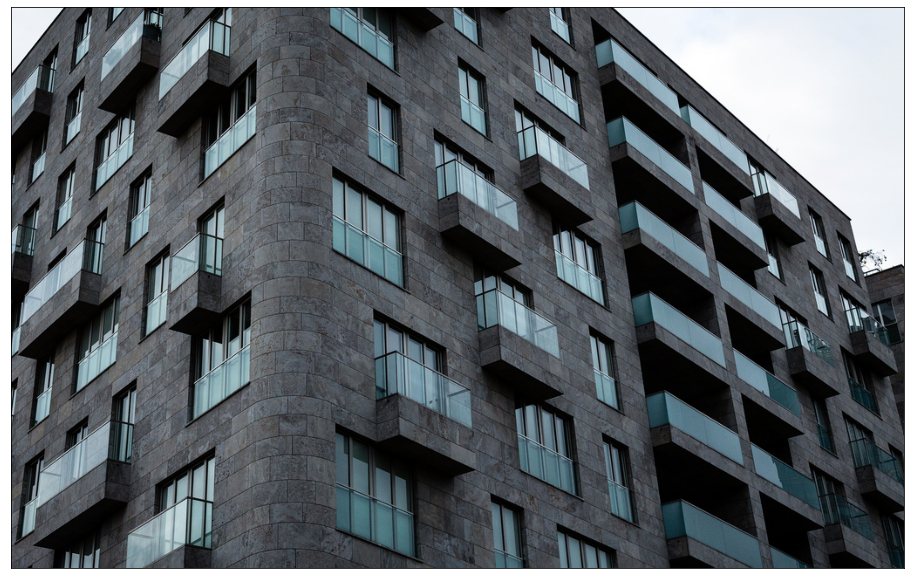

In [8]:
for test_loader in test_loaders:
    batch = next(iter(test_loader))
    show(make_grid(batch[4][0]))
    show(make_grid(batch[4][1]))

In [1]:
from src.models.components.imsisr import *
import torch

In [2]:
net = IMSISR(mode=3, init_q=True).cuda()

In [3]:
x = torch.rand(1,3,48,48).cuda()
y = torch.rand(1,3,64,69).cuda()
size = [64, 69]

In [4]:
out = net(x, size)

this!!!


In [5]:
loss = (out - y).mean()
loss.backward()
for name, param in net.named_parameters():
    if param.grad is None:
        print(name)

decoder.K.0.0.weight
decoder.K.0.0.bias


In [4]:
with torch.no_grad():
    for split in range(5):
        print((net(x,size,split) - net(x,size,0)).sum())

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


In [ ]:
data = SRData(name='benchmark',split='Set14', bin=False, patch_size=0)

In [ ]:
data[0]

In [ ]:
data.lr_dir

In [7]:
import torch

In [16]:
torch.cuda.memory_reserved()

2097152

In [11]:
net = LIIF().cuda()
with torch.no_grad():
    for dataset in dm.data_test:
        for sample in dataset:
            for scale in [2,3,4]:
                net(sample[scale][0].unsqueeze(0),sample[scale][1].shape[-2:])

KeyboardInterrupt: 

In [5]:
def to_pixel_samples(inp, size, ranges=None, flatten=True):
    """ Convert the image to coord-RGB pairs.
        img: Tensor, (3, H, W)
    """
    coord_seqs = []
    for i, n in enumerate(size):
        if ranges is None:
            v0, v1 = -1, 1
        else:
            v0, v1 = ranges[i]
        r = (v1 - v0) / (2 * n)
        seq = v0 + r + (2 * r) * torch.arange(n, device=inp.device).float()
        coord_seqs.append(seq)
    hr_coord = torch.stack(torch.meshgrid(*coord_seqs, indexing='ij'), dim=-1)
    if flatten:
        hr_coord = hr_coord.view(-1, hr_coord.shape[-1])

    cell = torch.ones_like(hr_coord)
    cell[:, 0] *= 2 / size[-2]
    cell[:, 1] *= 2 / size[-1]
    print(hr_coord.shape, cell.shape)

In [6]:
to_pixel_samples(torch.rand(16,3,48,48).cuda(), [96,96])

torch.Size([9216, 2]) torch.Size([9216, 2])


In [2]:
import torch
import torch.nn.functional as F

In [14]:
x = torch.arange(1, 1 + 1*2*5*5).view(1,2,5,5)
x

tensor([[[[ 1,  2,  3,  4,  5],
          [ 6,  7,  8,  9, 10],
          [11, 12, 13, 14, 15],
          [16, 17, 18, 19, 20],
          [21, 22, 23, 24, 25]],

         [[26, 27, 28, 29, 30],
          [31, 32, 33, 34, 35],
          [36, 37, 38, 39, 40],
          [41, 42, 43, 44, 45],
          [46, 47, 48, 49, 50]]]])

In [17]:
unf = F.unfold(x.float(), kernel_size=3, padding=1).view(1,2,9,5,5)
var, mean = torch.var_mean(unf, dim=2, keepdim=False)
(x-mean)/torch.sqrt(var)

tensor([[[[-0.2804, -0.3123, -0.1867, -0.0840,  0.4600],
          [ 0.3457,  0.0000,  0.0000,  0.0000,  0.6176],
          [ 0.4928,  0.0000,  0.0000,  0.0000,  0.6603],
          [ 0.5564,  0.0000,  0.0000,  0.0000,  0.6744],
          [ 1.2340,  0.8989,  0.8889,  0.8797,  1.2972]],

         [[ 0.8519,  0.4914,  0.4972,  0.5027,  0.9302],
          [ 0.6193,  0.0000,  0.0000,  0.0000,  0.6813],
          [ 0.6274,  0.0000,  0.0000,  0.0000,  0.6810],
          [ 0.6333,  0.0000,  0.0000,  0.0000,  0.6805],
          [ 1.1369,  0.7750,  0.7727,  0.7705,  1.1721]]]])

In [18]:
var

tensor([[[[  7.6944,  10.2500,  12.7500,  15.7500,  16.8611],
          [ 23.2500,  19.5000,  19.5000,  19.5000,  35.2500],
          [ 45.7500,  19.5000,  19.5000,  19.5000,  65.2500],
          [ 80.7500,  19.5000,  19.5000,  19.5000, 107.7500],
          [103.5278, 100.2500, 110.2500, 120.7500, 137.6944]],

         [[236.8611, 222.7500, 237.7500, 253.2500, 287.6945],
          [260.7500,  19.5000,  19.5000,  19.5000, 310.2500],
          [345.7500,  19.5000,  19.5000,  19.5000, 402.7500],
          [443.2500,  19.5000,  19.5000,  19.5000, 507.7500],
          [541.0278, 500.2500, 522.7500, 545.7500, 616.8611]]]])

In [19]:
mean

tensor([[[[ 1.7778,  3.0000,  3.6667,  4.3333,  3.1111],
          [ 4.3333,  7.0000,  8.0000,  9.0000,  6.3333],
          [ 7.6667, 12.0000, 13.0000, 14.0000,  9.6667],
          [11.0000, 17.0000, 18.0000, 19.0000, 13.0000],
          [ 8.4444, 13.0000, 13.6667, 14.3333,  9.7778]],

         [[12.8889, 19.6667, 20.3333, 21.0000, 14.2222],
          [21.0000, 32.0000, 33.0000, 34.0000, 23.0000],
          [24.3333, 37.0000, 38.0000, 39.0000, 26.3333],
          [27.6667, 42.0000, 43.0000, 44.0000, 29.6667],
          [19.5556, 29.6667, 30.3333, 31.0000, 20.8889]]]])

In [20]:
round(2.5)

2

In [21]:
from torchvision.io import read_image, ImageReadMode
from pathlib import Path
from torchvision import transforms
from PIL import Image
import math

In [17]:
f_lr = Path(r'data\benchmark\Urban100\LR_bicubic\X4\img001x4.png')
f_hr = Path(r'data\benchmark\Urban100\HR\img001.png')

In [19]:
lr = read_image(str(f_lr), ImageReadMode.RGB)
hr = read_image(str(f_hr), ImageReadMode.RGB)

In [23]:
s = 2.5
h_lr = math.floor(hr.shape[-2] / s + 1e-9)
w_lr = math.floor(hr.shape[-1] / s + 1e-9)
img = hr[:, :round(h_lr * s), :round(w_lr * s)]
img_down = 